In [17]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
input_directory  = r"C:\Users\clark.roll\python coding\code_personal\Data512\Course Project\Data Analysis and Modeling\input_files"
viz_directory    = r"C:\Users\clark.roll\python coding\code_personal\Data512\Course Project\Data Analysis and Modeling\visualizations"
output_directory = r"C:\Users\clark.roll\python coding\code_personal\Data512\Course Project\Data Analysis and Modeling\output_files"

In [3]:
survey                 = 'activity_survey_subset.csv'
fullYear_daily_aqi     = 'AQI_fullYear_daily_avg.csv'
seasonal_daily_aqi     = 'AQI_seasonal_daily_avg.csv'
parks                  = 'parks_data.csv'
aqi_cats_perc          = 'activity_reduction_perc_by_AQI.csv'

# Full paths for each file
survey_path     = os.path.join(input_directory, survey)
year_aqi_path   = os.path.join(input_directory, fullYear_daily_aqi)
szn_aqi_path    = os.path.join(input_directory, seasonal_daily_aqi)
parks_path      = os.path.join(input_directory, parks)
aqi_cat_path    = os.path.join(input_directory, aqi_cats_perc)

# load dataframes
survey_df        = pd.read_csv(survey_path)
aqi_cats_perc_df = pd.read_csv(aqi_cat_path)
aqi_y_df         = pd.read_csv(year_aqi_path)
aqi_s_df         = pd.read_csv(szn_aqi_path)
parks_df         = pd.read_csv(parks_path)

In [4]:
def gen_png_savepath(filename:str):
    save_path = os.path.join(viz_directory, filename)
    return save_path

Reduction Factor Calculation
The reduction factor represents the proportion of the population that would reduce or eliminate outdoor activities on a given day based on the AQI value for that day.

Steps:

For each AQI value:
Match the value to the appropriate range (threshold_min, threshold_max) in the AQI thresholds dataset (aqi_cats_perc_df).
Identify whether the action is "Reduce" or "Eliminate."
Use the Percentage value corresponding to the matched range. Convert this percentage into a decimal by dividing by 100.
If the AQI value does not fall within any defined range, the reduction factor is set to 0.

In [5]:
def calculate_reduction_factor(aqi_value: float,
                               thresholds_df: pd.DataFrame,
                               action_type: str
                              ) -> float:
    """
    Calculate the reduction factor for a given AQI value.

    Parameters
    ----------
    aqi_value : float
        The AQI value for the day.
    thresholds_df : pd.DataFrame
        DataFrame containing AQI thresholds, actions, and percentages.
        Must have columns: ['threshold_min', 'threshold_max', 'Action', 'Percentage'].
    action_type : str
        The action type ('Reduce' or 'Eliminate').

    Returns
    -------
    float
        The reduction factor (0 to 1) for the specified AQI value and action type.
    """
    relevant_thresholds = thresholds_df[thresholds_df["Action"] == action_type]
    for _, row in relevant_thresholds.iterrows():
        if row["threshold_min"] <= aqi_value < row["threshold_max"]:
            return row["Percentage"] / 100  # Convert percentage to decimal
    return 0.0  # No reduction if AQI is out of all defined ranges

In [5]:
# Apply the reduction factor calculation for both "Reduce" and "Eliminate" actions
aqi_y_df["reduce_factor"] = aqi_y_df["aqi"].apply(
    lambda x: calculate_reduction_factor(x, aqi_cats_perc_df, "Reduce")
)
aqi_y_df["eliminate_factor"] = aqi_y_df["aqi"].apply(
    lambda x: calculate_reduction_factor(x, aqi_cats_perc_df, "Eliminate")
)

In [6]:
# Add a "Year" column to the daily AQI dataset
aqi_y_df["date"] = pd.to_datetime(aqi_d_df["date"])
aqi_y_df["Year"] = aqi_y_df["date"].dt.year

# Initialize category counts columns for each AQI category
for _, row in aqi_cats_perc_df.iterrows():
    category_name = row["AQI Category"]
    aqi_d_df[category_name] = aqi_d_df["aqi"].apply(
        lambda x: 1 if row["threshold_min"] <= x < row["threshold_max"] else 0
    )

In [10]:
# Group by year to calculate annual summaries
annual_aqi_summary = aqi_y_df.groupby("Year").agg(
    average_reduce_factor=("reduce_factor", "mean"),
    average_eliminate_factor=("eliminate_factor", "mean"),
    **{
        f"{row['AQI Category']} Days": (row["AQI Category"], "sum")
        for _, row in aqi_cats_perc_df.iterrows()
    }).reset_index()

annual_aqi_summary["Total Days"] = aqi_d_df.groupby("Year")["date"].count().values

In [22]:
annual_aqi_summary

,Year,average_reduce_factor,average_eliminate_factor,Good Days,Moderate Days,Unhealthy for sensitive grps Days,Unhealthy Days,Very unhealthy Days,Hazardous Days,Total Days,Estimated Reduction,Adjusted Attendance
0,1974,0.034650,0.011086,151,27,5,0,0,0,184,193729.497884,4.042151e+06
1,1975,0.026702,0.009404,141,15,4,0,0,0,161,152942.575847,4.082937e+06
2,1978,0.035677,0.013294,19,2,1,0,0,0,23,207438.043650,4.028442e+06
3,1979,0.035153,0.010035,81,20,2,0,0,0,107,191411.608126,4.044468e+06
4,1980,0.053014,0.021585,130,33,8,2,0,0,174,315991.938135,3.919888e+06
5,1981,0.061212,0.020088,122,38,11,0,0,0,178,344378.494702,3.891502e+06
6,1982,0.036687,0.015842,145,15,7,1,0,0,168,222506.805590,4.013373e+06
7,1983,0.021063,0.006610,81,10,1,0,0,0,93,117219.372123,4.118661e+06
8,1984,0.046604,0.017360,149,19,11,0,0,0,183,270946.801312,3.964933e+06
9,1985,0.012142,0.003689,168,15,0,0,0,0,184,67058.809191,4.168821e+06


,date_local,aqi
0,1998-01-01,6.000000
1,1998-01-02,10.000000
2,1998-01-03,11.000000
3,1998-01-04,10.000000
4,1998-01-05,11.000000
...,...,...
8733,2021-12-27,25.000000
8734,2021-12-28,28.000000
8735,2021-12-29,35.500000
8736,2021-12-30,34.666667


MODEL EXTENSION: PREDICTING AQI

In [34]:
# Handle missing AQI data using linear interpolation
aqi_full_year_df = aqi_y_df.copy()
aqi_full_year_df.rename(columns={"date_local":"date"}, inplace=True)

In [35]:
# Ensure 'date' column is datetime and set as index
aqi_full_year_df["date"] = pd.to_datetime(aqi_full_year_df["date"])
aqi_full_year_df.set_index("date", inplace=True)

# Generate a complete daily date range
full_date_range = pd.date_range(
    start=aqi_full_year_df.index.min(),
    end=aqi_full_year_df.index.max(),
    freq="D"
)

# Reindex to ensure daily frequency, filling missing dates with NaN
aqi_full_year_df = aqi_full_year_df.reindex(full_date_range)

# Rename the index to 'date' for clarity
aqi_full_year_df.index.name = "date"

# Interpolate missing values
aqi_full_year_df["aqi"] = aqi_full_year_df["aqi"].interpolate(method="time")

# Ensure index is now consistent with daily frequency
aqi_full_year_df.index.freq = "D"

In [ ]:
# Aggregate AQI data into weekly averages
weekly_aqi = aqi_full_year_df.resample("W").mean()

# Reset the index for clarity
weekly_aqi.reset_index(inplace=True)
weekly_aqi.rename(columns={"date": "Week"}, inplace=True)

In [36]:
# Check if all missing values are resolved
remaining_missing = aqi_full_year_df["aqi"].isnull().sum()
remaining_missing

0

In [37]:
aqi_full_year_df

,aqi
date,
1998-01-01,6.000000
1998-01-02,10.000000
1998-01-03,11.000000
1998-01-04,10.000000
1998-01-05,11.000000
...,...
2021-12-27,25.000000
2021-12-28,28.000000
2021-12-29,35.500000


In [38]:
# Refit the SARIMA model with proper frequency
sarima_model = SARIMAX(
    aqi_full_year_df["aqi"],
    order=(1, 1, 1),  # ARIMA component
    seasonal_order=(1, 1, 1, 365),  # Seasonal component with yearly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_fitted = sarima_model.fit(disp=False)

# Project AQI data 20 years into the future
forecast_sarima = sarima_fitted.get_forecast(steps=20 * 365)  # Daily projections
forecast_sarima_summary = forecast_sarima.summary_frame(alpha=0.05)  # 95% CI

# Generate future dates for 20 years
future_dates_sarima = pd.date_range(
    start=aqi_full_year_df.index[-1] + pd.Timedelta(days=1),
    periods=20 * 365,
    freq="D"
)

KeyboardInterrupt: 

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_m

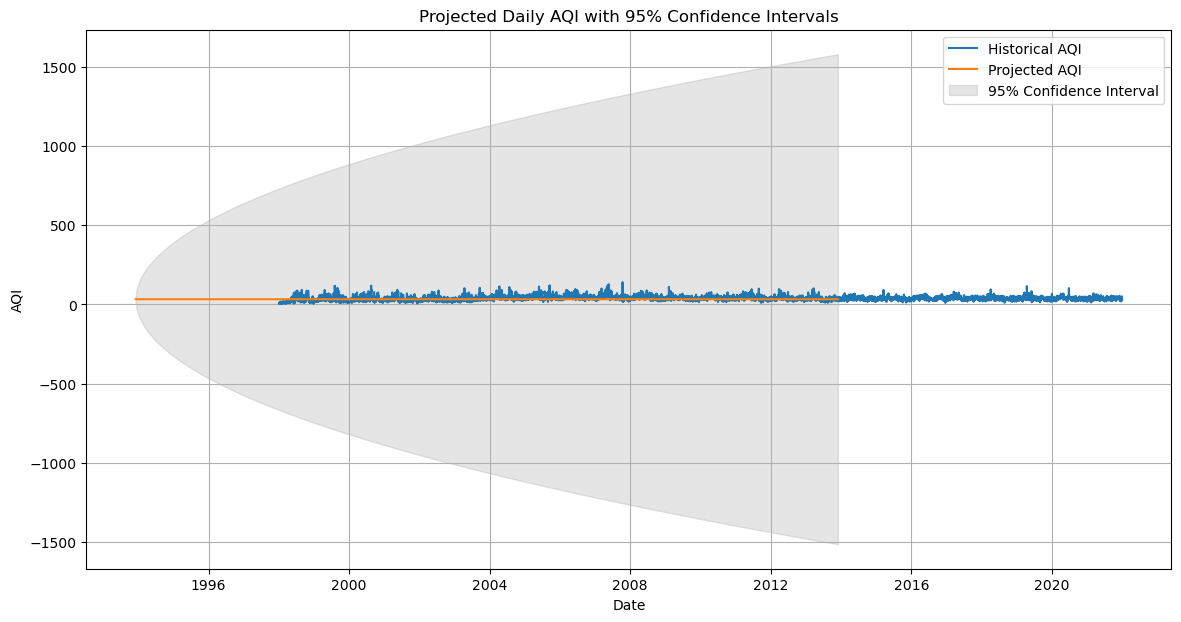

In [14]:


# Fit an ARIMA model to the cleaned AQI data
arima_model = ARIMA(aqi_full_year_df["aqi"], order=(1, 1, 0))  # ARIMA(1,1,0)
arima_fitted = arima_model.fit()

# Project AQI data 20 years into the future
forecast = arima_fitted.get_forecast(steps=20 * 365)  # Daily projections for 20 years
forecast_summary = forecast.summary_frame(alpha=0.05)  # 95% confidence intervals

# Plot historical and projected AQI with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(aqi_full_year_df.index, aqi_full_year_df["aqi"], label="Historical AQI")
plt.plot(
    forecast_summary.index, forecast_summary["mean"], label="Projected AQI"
)
plt.fill_between(
    forecast_summary.index,
    forecast_summary["mean_ci_lower"],
    forecast_summary["mean_ci_upper"],
    color="gray",
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.title("Projected Daily AQI with 95% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Update forecast index with future dates
forecast_sarima_summary.index = future_dates_sarima

# Plot historical and projected AQI with SARIMA adjustments
plt.figure(figsize=(14, 7))
plt.plot(aqi_full_year_df.index, aqi_full_year_df["aqi"], label="Historical AQI")
plt.plot(
    forecast_sarima_summary.index, forecast_sarima_summary["mean"], label="Projected AQI"
)
plt.fill_between(
    forecast_sarima_summary.index,
    forecast_sarima_summary["mean_ci_lower"],
    forecast_sarima_summary["mean_ci_upper"],
    color="gray",
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.title("Projected Daily AQI with SARIMA Adjustments and 95% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid()
plt.show()

In [12]:
annual_aqi_summary.to_csv('annual_reduction_factor_summary.csv', index = False)

Plan to Estimate Park Attendance Impacts
Baseline Attendance:

Use the annual attendance data from parks_df.
Convert the Annual Attendance column to numeric if necessary.
Apply Reduction Factors:

Use the annual reduction factors (average_reduce_factor and average_eliminate_factor) to estimate the percentage reduction in attendance.
Adjusted Attendance:


In [20]:
# Step 1: Prepare a DataFrame to hold results for each park
parks_summary = parks_df.copy()

# Initialize columns for estimated reduction and adjusted attendance for each park
parks_summary["Estimated Reduction"] = 0.0
parks_summary["Adjusted Attendance"] = 0.0

# Step 2: Calculate impacts for each park
for _, annual_row in annual_aqi_summary.iterrows():
    # Extract the year's reduction factors
    year = annual_row["Year"]
    reduce_factor = annual_row["average_reduce_factor"]
    eliminate_factor = annual_row["average_eliminate_factor"]
    total_factor = reduce_factor + eliminate_factor

    # Apply reduction factors to each park's annual attendance
    parks_summary[f"Estimated Reduction {int(year)}"] = (
        parks_summary["Annual Attendance"] * total_factor
    )
    parks_summary[f"Adjusted Attendance {int(year)}"] = (
        parks_summary["Annual Attendance"] 
        - parks_summary[f"Estimated Reduction {int(year)}"]
    )


In [21]:
parks_summary

,Park District,Park,Annual Attendance,Fiscal Year 22-23 Expenditures,Estimated Reduction,Adjusted Attendance,Estimated Reduction 1974,Adjusted Attendance 1974,Estimated Reduction 1975,Adjusted Attendance 1975,...,Estimated Reduction 2017,Adjusted Attendance 2017,Estimated Reduction 2018,Adjusted Attendance 2018,Estimated Reduction 2019,Adjusted Attendance 2019,Estimated Reduction 2020,Adjusted Attendance 2020,Estimated Reduction 2021,Adjusted Attendance 2021
0,1,Alfred B. Maclay Gardens,84260.0,859815,0.0,0.0,3853.661457,80406.338543,3042.329207,81217.670793,...,1428.515091,82831.484909,1650.470562,82609.529438,2203.160333,82056.839667,1397.655354,82862.344646,1259.468842,83000.531158
1,1,Bald Point,38963.0,279339,0.0,0.0,1781.986842,37181.013158,1406.815486,37556.184514,...,660.565316,38302.434684,763.200623,38199.799377,1018.772087,37944.227913,646.295342,38316.704658,582.395971,38380.604029
2,1,Big Lagoon,116435.0,2386938,0.0,0.0,5325.196674,111109.803326,4204.054132,112230.945868,...,1973.998987,114461.001013,2280.708995,114154.291005,3044.445447,113390.554553,1931.355342,114503.644658,1740.401787,114694.598213
3,1,Blackwater Heritage Trail,159609.0,116134,0.0,0.0,7299.775118,152309.224882,5762.913866,153846.086134,...,2705.956150,156903.043850,3126.393970,156482.606030,4173.323257,155435.676743,2647.500277,156961.499723,2385.741305,157223.258695
4,1,Blackwater River,82890.0,320277,0.0,0.0,3791.004013,79098.995987,2992.863375,79897.136625,...,1405.288582,81484.711418,1623.635235,81266.364765,2167.338714,80722.661286,1374.930599,81515.069401,1238.990889,81651.009111
5,1,Camp Helen,57380.0,1452928,0.0,0.0,2624.294973,54755.705027,2071.787917,55308.212083,...,972.800806,56407.199194,1123.949690,56256.050310,1500.324471,55879.675529,951.785713,56428.214287,857.682437,56522.317563
6,1,Deer Lake,26019.0,84479,0.0,0.0,1189.988339,24829.011661,939.453639,25079.546361,...,441.117187,25577.882813,509.655751,25509.344249,680.323151,25338.676849,431.587879,25587.412121,388.916684,25630.083316
7,1,St. George Island,215427.0,878451,0.0,0.0,9852.631458,205574.368542,7778.303514,207648.696486,...,3652.275344,211774.724656,4219.747469,211207.252531,5632.805852,209794.194148,3573.376452,211853.623548,3220.075887,212206.924113
8,1,Econfina River,10668.0,4579,0.0,0.0,487.904823,10180.095177,385.183574,10282.816426,...,180.861607,10487.138393,208.962971,10459.037029,278.937983,10389.062017,176.954514,10491.045486,159.458979,10508.541021
9,1,Eden Gardens,42695.0,143031,0.0,0.0,1952.671207,40742.328793,1541.564746,41153.435254,...,723.836361,41971.163639,836.302405,41858.697595,1116.353316,41578.646684,708.199565,41986.800435,638.179708,42056.820292


In [17]:
# Calculate total annual attendance for all parks
total_annual_attendance = parks_df["Annual Attendance"].sum()

# Step 2: Estimate attendance impacts for all parks combined
annual_aqi_summary["Estimated Reduction"] = (
    total_annual_attendance
    * (annual_aqi_summary["average_reduce_factor"] + annual_aqi_summary["average_eliminate_factor"])
)

annual_aqi_summary["Adjusted Attendance"] = (
    total_annual_attendance - annual_aqi_summary["Estimated Reduction"]
)

In [18]:
total_annual_attendance

4235880.0

In [7]:
# Remove latitude and longitude columns and compute average AQI per date
daily_aqi_df["date_local"] = pd.to_datetime(daily_aqi_df["date_local"])  # Ensure dates are in datetime format
avg_daily_aqi_df = daily_aqi_df.groupby("date_local", as_index=False).agg({"aqi": "mean"})

In [9]:
avg_daily_aqi_df.rename(columns={"date_local":"date"}, inplace = True)

In [11]:
avg_daily_aqi_df.to_csv("avg_daily_aqi.csv", index=False)

In [7]:
## Preprocess our survey data

# just want people who do outdoor activities
# and people who said they do reduce their activities due to smoke
filtered_survey = survey_df[
    (survey_df['outside_activity_frequency'] != "Never") &  # Exclude those who never do outdoor activities
    (survey_df['reduced_outdoor_activities_due_to_smoke'] == "Yes")  # Include only those who reduce activity
]

# Filter out rows with invalid or missing thresholds
cleaned_survey = filtered_survey.dropna(subset=['min_aqi_reduce_activity', 'min_aqi_eliminate_activity'])

In [8]:
# Grouping by thresholds for 'reduce' and 'eliminate'
reduce_group_summary = cleaned_survey['min_aqi_reduce_activity'].value_counts(normalize=True).sort_index()
eliminate_group_summary = cleaned_survey['min_aqi_eliminate_activity'].value_counts(normalize=True).sort_index()

# Combine summaries into a single dataframe for better visualization
threshold_summary = pd.DataFrame({
    "Reduce (%)": (reduce_group_summary * 100).round(2),
    "Eliminate (%)": (eliminate_group_summary * 100).round(2)
}).fillna(0)

# Display the threshold summary
threshold_summary

,Reduce (%),Eliminate (%)
0-50:\nGood,0.21,0.21
101-150:\nUnhealthy for\n Sensitive Grps.,52.89,20.66
151-200:\nUnhealthy,27.55,48.42
201-300:\nVery Unhealthy,3.86,19.83
301+:\nHazardous,0.69,5.79
51-100:\nModerate,12.12,2.41
I am not familiar with this rating,2.69,2.69
